In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=64,
    in_channels = 3,
    out_channels = 3,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    
    down_block_types = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    mid_block_type = 'UNetMidBlock2D',
    up_block_types = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels= (64, 128, 160, 224),
    num_class_embeds=2
)

unet.eval()
unet.to(device)

In [19]:
# Reset peak memory stats
torch.cuda.reset_peak_memory_stats(device)

x = torch.randn(1, 3, 64, 64).to(device)
t = torch.tensor([0]).to(device)
y = torch.tensor([0]).to(device)

with torch.no_grad():
    output = unet(x,t,y).sample
    print(output.shape)
    
# Print peak memory utilization
peak_memory_bytes = torch.cuda.max_memory_allocated(device)
peak_memory_MB = peak_memory_bytes / (1024 ** 2)
print(f"Peak GPU memory usage: {peak_memory_MB:.2f} MB")

torch.Size([1, 3, 64, 64])
Peak GPU memory usage: 89.88 MB


In [15]:
# Reset peak memory stats
torch.cuda.reset_peak_memory_stats(device)

x = torch.randn(1, 3, 128, 128).to(device)
t = torch.tensor([0]).to(device)
y = torch.tensor([0]).to(device)

with torch.no_grad():
    output = unet(x,t,y).sample
    print(output.shape)
    
# Print peak memory utilization
peak_memory_bytes = torch.cuda.max_memory_allocated(device)
peak_memory_MB = peak_memory_bytes / (1024 ** 2)
print(f"Peak GPU memory usage: {peak_memory_MB:.2f} MB")

torch.Size([1, 3, 128, 128])
Peak GPU memory usage: 132.73 MB


In [14]:
# Reset peak memory stats
torch.cuda.reset_peak_memory_stats(device)

x = torch.randn(1, 3, 256, 256).to(device)
t = torch.tensor([0]).to(device)
y = torch.tensor([0]).to(device)

with torch.no_grad():
    output = unet(x,t,y).sample
    print(output.shape)
    
# Print peak memory utilization
peak_memory_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
print(f"Peak GPU memory usage: {peak_memory_MB:.2f} MB")

torch.Size([1, 3, 256, 256])
Peak GPU memory usage: 301.29 MB


In [20]:
# Reset peak memory stats
torch.cuda.reset_peak_memory_stats(device)

x = torch.randn(1, 3, 512,512).to(device)
t = torch.tensor([0]).to(device)
y = torch.tensor([0]).to(device)

with torch.no_grad():
    output = unet(x,t,y).sample
    print(output.shape)
    
# Print peak memory utilization
peak_memory_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
print(f"Peak GPU memory usage: {peak_memory_MB:.2f} MB")

torch.Size([1, 3, 512, 512])
Peak GPU memory usage: 1039.26 MB


# Using VAE to create latents

In [3]:
from diffusers.models import AutoencoderKL
vae = AutoencoderKL.from_pretrained("sd-legacy/stable-diffusion-v1-5",
                                    subfolder='vae')
vae.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [4]:
from datasets import load_dataset

ds = load_dataset("ashraq/tmdb-celeb-10k",split='train')


In [5]:
from torchvision import transforms
from PIL import Image

image = ds[0]['image']

transform = transforms.Compose([ transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5]),
])

image = transform(image).unsqueeze(0).to(device)

In [10]:
image= torch.randn((5,3,512,512))
print(torch.mean(image),torch.std(image))

with torch.no_grad():
    latent = vae.encode(image.to(device)).latent_dist.sample() * vae.config.scaling_factor
print(torch.mean(latent),torch.var(latent))

tensor(0.0006) tensor(0.9994)
tensor(-0.3073, device='cuda:0') tensor(0.6071, device='cuda:0')


In [58]:
with torch.no_grad():
    latent = vae.encode(image).latent_dist.sample() * vae.config.scaling_factor
    print(latent.shape)

torch.Size([1, 4, 64, 64])


torch.Size([64, 64])


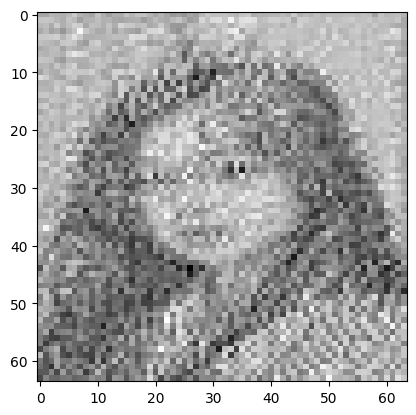

In [59]:
print(torch.mean(latent,dim=(0,1)).cpu().shape)

plt.imshow(torch.mean(latent,dim=(0,1)).cpu(),cmap='grey')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02821225..0.84664214].


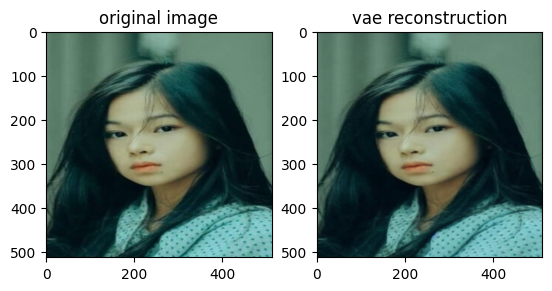

In [62]:
with torch.no_grad():
    recon_image = vae.decode(latent / vae.config.scaling_factor).sample


plt.subplot(1,2,1)
plt.imshow(image[0].cpu().permute(1,2,0)*0.5+0.5)
plt.title('original image')
plt.subplot(1,2,2)
plt.title('vae reconstruction')
plt.imshow(recon_image[0].cpu().permute(1,2,0)*0.5+0.5)
plt.show()

# The UNET needs modifiation to have total 4 channels

In [2]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=64,
    in_channels = 4,
    out_channels = 4,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    
    down_block_types = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    mid_block_type = 'UNetMidBlock2D',
    up_block_types = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels= (64, 128, 160, 224),
    num_class_embeds=2
)

unet.eval()
unet.to(device)

UNet2DModel(
  (conv_in): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (class_embedding): Embedding(2, 256)
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2

In [3]:
# Reset peak memory stats
torch.cuda.reset_peak_memory_stats(device)

x = torch.randn(1, 4, 64,64).to(device)
t = torch.tensor([0]).to(device)
y = torch.tensor([0]).to(device)

with torch.no_grad():
    output = unet(x,t,y).sample
    print(output.shape)
    
# Print peak memory utilization
peak_memory_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
print(f"Peak GPU memory usage: {peak_memory_MB:.2f} MB")

torch.Size([1, 4, 64, 64])
Peak GPU memory usage: 89.86 MB
